In [2]:
from sympy import *
from IPython.display import display, Math
import numpy as np
init_printing(use_unicode=True)
import plotly.express as px
import plotly.graph_objects as go

In [5]:
from sympy import solve
x, y, s, C, sigma, mu, delta, alpha, beta, ro, eta, b, lambd = symbols(
    'x y s C σ μ δ α β ρ η b λ')

In [6]:
dxdt = x*(1-x) - (b/(1+s*x))*(1-exp(-ro*C))*x

In [7]:
display(Math('\dfrac{dx}{dt} = ' + latex(dxdt)))

<IPython.core.display.Math object>

In [41]:
params = {s:0.1, b:1.0, ro:1}

cs = []
xs =[]
sols_by_c = {}
for cur_C in np.linspace(0,5,50):
    sols_by_c[cur_C] = [sol for sol in solve(dxdt.subs({C:cur_C} | params), x)
                       if sol>=0]
    for curx in sols_by_c[cur_C]:
        cs.append(float(cur_C))
        xs.append(float(curx))
    

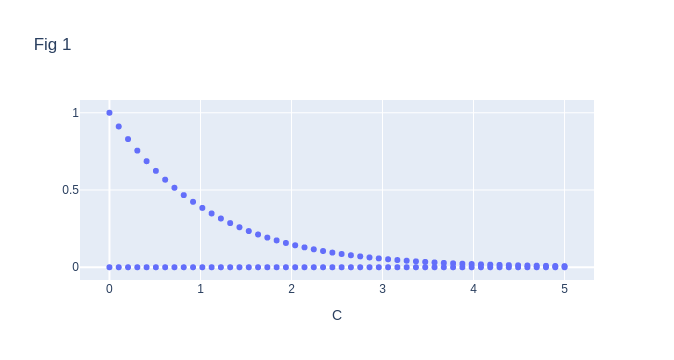

In [43]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=cs, y=xs, mode='markers', name = ""))
fig.update_layout(title="Fig 1")
fig.update_layout(xaxis={"title": "C"})